In [2]:
import os
import sys
# 如果当前代码文件运行测试需要加入修改路径，避免出现后导包问题
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, os.path.join(BASE_DIR))

PYSPARK_PYTHON = "/root/miniconda3/envs/test/bin/python3.6"
# 当存在多个版本时，不指定很可能会导致出错
os.environ["PYSPARK_PYTHON"] = PYSPARK_PYTHON
os.environ["PYSPARK_DRIVER_PYTHON"] = PYSPARK_PYTHON

from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel
from offline import SparkSessionBase

class CtrLogisticRegression(SparkSessionBase):

    SPARK_APP_NAME = "ctrLogisticRegression"
    ENABLE_HIVE_SUPPORT = True

    def __init__(self):

        self.spark = self._create_spark_hbase()

ctr = CtrLogisticRegression()

In [3]:
ctr.spark.sql("use profile")

DataFrame[]

In [4]:
# 用户行为日志读取
user_article_basic = ctr.spark.sql("select user_id,article_id,clicked from user_article_basic")
user_article_basic.show()

+-------------------+----------+-------+
|            user_id|article_id|clicked|
+-------------------+----------+-------+
|1105045287866466304|     14225|  false|
|1106476833370537984|     14208|  false|
|1109980466942836736|     19233|  false|
|1109980466942836736|     44737|  false|
|1109993249109442560|     17283|  false|
|1111189494544990208|     19322|  false|
|                  1|     44386|   true|
|                  1|     44696|  false|
|                 10|     43907|  false|
|1105093883106164736|    140357|  false|
|1106473203766657024|     16005|  false|
|1108264901190615040|     15196|  false|
|1109976363453906944|     13728|   true|
|1109979805106831360|     43907|  false|
|                 33|     13570|  false|
|                  1|     17632|   true|
|1106473203766657024|     17665|  false|
|1109976363453906944|     44664|  false|
|1109979805106831360|     17283|  false|
|1111189494544990208|     44368|  false|
+-------------------+----------+-------+
only showing top

In [5]:
# 因为测试数据的article_profile中只有1~10篇文章，与用户行为表的article_id没有交集，因此转换article_id
def change_article_id(row):
    if row.article_id == 14225:
        article_id = 1
    elif row.article_id == 14208:
        article_id = 2
    elif row.article_id == 44386:
        article_id = 3
    elif row.article_id == 44696:
        article_id = 4
    elif row.article_id == 43907:
        article_id = 5
    elif row.article_id == 140357:
        article_id = 6
    elif row.article_id == 16005:
        article_id = 7 
    elif row.article_id == 13570:
        article_id = 8
    elif row.article_id == 17632:
        article_id = 9
    else:
        article_id = 10
    return row.user_id,article_id,row.clicked

user_article_basic = user_article_basic.rdd.map(change_article_id).toDF(["user_id","article_id","clicked"])

user_article_basic.show()

+-------------------+----------+-------+
|            user_id|article_id|clicked|
+-------------------+----------+-------+
|1105045287866466304|         1|  false|
|1106476833370537984|         2|  false|
|1109980466942836736|        10|  false|
|1109980466942836736|        10|  false|
|1109993249109442560|        10|  false|
|1111189494544990208|        10|  false|
|                  1|         3|   true|
|                  1|         4|  false|
|                 10|         5|  false|
|1105093883106164736|         6|  false|
|1106473203766657024|         7|  false|
|1108264901190615040|        10|  false|
|1109976363453906944|        10|   true|
|1109979805106831360|         5|  false|
|                 33|         8|  false|
|                  1|         9|   true|
|1106473203766657024|        10|  false|
|1109976363453906944|        10|  false|
|1109979805106831360|        10|  false|
|1111189494544990208|        10|  false|
+-------------------+----------+-------+
only showing top

In [6]:
# 2.读取用户画像
user_profile_hbase = ctr.spark.sql("select user_id,information.birthday,information.gender,article_partial,env from user_profile_hbase")
user_profile_hbase.show()

+--------------------+--------+------+--------------------+-----+
|             user_id|birthday|gender|     article_partial|  env|
+--------------------+--------+------+--------------------+-----+
|              user:1|     0.0|  null|Map(17:span -> 0....|Map()|
|             user:10|     0.0|  null|Map(17:span -> 0....|Map()|
|             user:11|     0.0|  null|               Map()|Map()|
|user:110249052282...|     0.0|  null|               Map()|Map()|
|user:110256196274...|     0.0|  null|               Map()|Map()|
|user:110319567345...|     0.0|  null|Map(17:production...|Map()|
|user:110504528786...|     0.0|  null|Map(17:production...|Map()|
|user:110509388310...|     0.0|  null|Map(17:production...|Map()|
|user:110510518565...|     0.0|  null|Map(17:production...|Map()|
|user:110639618314...|     0.0|  null|Map(17:production...|Map()|
|user:110647320376...|     0.0|  null|Map(17:production...|Map()|
|user:110647683337...|     0.0|  null|Map(17:production...|Map()|
|user:1108

In [7]:
_schema = StructType([
    StructField("user_id",LongType()),
    StructField("birthday",DoubleType()),
    StructField("gender",BooleanType()),
    StructField("weights",MapType(StringType(),DoubleType()))
])

In [8]:
def get_user_id(row):
    return int(row.user_id.split(":")[1]),row.birthday,row.gender,row.article_partial

In [9]:
# 3.用户行为日志和用户画像合并
user_profile_hbase_temp = user_profile_hbase.rdd.map(get_user_id)
user_profile_hbase_schema = ctr.spark.createDataFrame(user_profile_hbase_temp,schema=_schema)

In [10]:
train = user_article_basic.join(user_profile_hbase_schema,on=["user_id"],how="left")
train.show()

+-------------------+----------+-------+--------+------+--------------------+
|            user_id|article_id|clicked|birthday|gender|             weights|
+-------------------+----------+-------+--------+------+--------------------+
|1106473203766657024|         7|  false|     0.0|  null|Map(17:production...|
|1106473203766657024|        10|  false|     0.0|  null|Map(17:production...|
|1106473203766657024|        10|  false|     0.0|  null|Map(17:production...|
|1106473203766657024|         3|  false|     0.0|  null|Map(17:production...|
|1106473203766657024|        10|  false|     0.0|  null|Map(17:production...|
|1106473203766657024|        10|  false|     0.0|  null|Map(17:production...|
|1106473203766657024|        10|  false|     0.0|  null|Map(17:production...|
|1106473203766657024|        10|  false|     0.0|  null|Map(17:production...|
|1106473203766657024|        10|  false|     0.0|  null|Map(17:production...|
|1106473203766657024|        10|  false|     0.0|  null|Map(17:p

In [11]:
# 4.读取文章向量，与其合并
ctr.spark.sql("use article")
article_vector = ctr.spark.sql("select * from article_vector")

In [12]:
train_s = train.join(article_vector,on=["article_id"],how="left").drop("birthday").drop("gender")
train_s.show()

+----------+-------------------+-------+--------------------+----------+--------------------+
|article_id|            user_id|clicked|             weights|channel_id|       articlevector|
+----------+-------------------+-------+--------------------+----------+--------------------+
|         7|1106473203766657024|  false|Map(17:production...|        17|[0.032613825, 0.0...|
|        10|1106473203766657024|  false|Map(17:production...|        17|[0.05536371, 0.05...|
|        10|1106473203766657024|  false|Map(17:production...|        17|[0.05536371, 0.05...|
|         3|1106473203766657024|  false|Map(17:production...|        17|[-0.014934189, 0....|
|        10|1106473203766657024|  false|Map(17:production...|        17|[0.05536371, 0.05...|
|        10|1106473203766657024|  false|Map(17:production...|        17|[0.05536371, 0.05...|
|        10|1106473203766657024|  false|Map(17:production...|        17|[0.05536371, 0.05...|
|        10|1106473203766657024|  false|Map(17:production...

In [13]:
# 5.读取文章画像的关键词权重，并与之合并
ctr.spark.sql("use article")
article_profile = ctr.spark.sql("select * from article_profile")
article_profile.show()

+----------+----------+--------------------+--------------------+
|article_id|channel_id|            keywords|              topics|
+----------+----------+--------------------+--------------------+
|         7|        17|Map(pre -> 0.2149...|[交易, eth, 合约, con...|
|         6|        17|Map(pre -> 0.3106...|[vue, https, &#, ...|
|         9|        17|Map(视图 -> 0.58758...|[item, 关键, goLink...|
|         5|        17|Map(pre -> 0.1436...|[obj, name, let, ...|
|         1|        17|Map(pre -> 0.1871...|[props, child, sp...|
|        10|        17|Map(auto -> 0.564...|[WebSocket, 源码, 程...|
|         3|        17|Map(对象 -> 0.16465...|[内存, Array, 数据类型,...|
|         8|        17|Map(pre -> 0.6574...|[模式, webpack, 插件,...|
|         2|        17|Map(name -> 0.237...|[match, 属性, node,...|
|         4|        17|Map(jpg -> 0.6861...|[bin, nodejs, 数据库...|
+----------+----------+--------------------+--------------------+



In [14]:
def article_profile_to_feature(row):

    try:
        weights = sorted(row.keywords.values())[:10]
    except Exception as e:
        weights = [0.0] * 10
    return row.article_id, weights
article_profile = article_profile.rdd.map(article_profile_to_feature).toDF(['article_id', 'article_weights'])

article_profile.show()

+----------+--------------------+
|article_id|     article_weights|
+----------+--------------------+
|         7|[0.09213260561227...|
|         6|[0.21955698728561...|
|         9|[0.07852160930633...|
|         5|[0.05401321128010...|
|         1|[0.07170990854501...|
|        10|[0.30014133453369...|
|         3|[0.16465455293655...|
|         8|[0.10025119781494...|
|         2|[0.06199097633361...|
|         4|[0.18988895416259...|
+----------+--------------------+



In [15]:
train_m = train_s.join(article_profile,on=["article_id"],how="left")
train_m.show()

+----------+-------------------+-------+--------------------+----------+--------------------+--------------------+
|article_id|            user_id|clicked|             weights|channel_id|       articlevector|     article_weights|
+----------+-------------------+-------+--------------------+----------+--------------------+--------------------+
|         7|1106473203766657024|  false|Map(17:production...|        17|[0.032613825, 0.0...|[0.09213260561227...|
|         7|1103195673450250240|  false|Map(17:production...|        17|[0.032613825, 0.0...|[0.09213260561227...|
|         7|1105045287866466304|  false|Map(17:production...|        17|[0.032613825, 0.0...|[0.09213260561227...|
|         7|1109995264376045568|  false|Map(17:Web -> 0.1...|        17|[0.032613825, 0.0...|[0.09213260561227...|
|         7|1105105185656537088|  false|Map(17:production...|        17|[0.032613825, 0.0...|[0.09213260561227...|
|         7|1110071654421102592|   true|Map(17:Web -> 0.1...|        17|[0.03261

In [28]:
# 6.解析出用户特征权重，及类型处理array---vector
columns = ["article_id","user_id","channel_id","articlevector","user_weights","article_weights","clicked"]

def get_user_weights(row):
    from pyspark.ml.linalg import Vectors
    
    try:
        user_weights = sorted([row.weights[key] for key in row.weights.keys() if key.split(":")[0]==str(row.channel_id)])[:10]
    except Exception:
        user_weights = [0.0]*10
    
    return row.article_id,row.user_id,row.channel_id,Vectors.dense(row.articlevector),Vectors.dense(user_weights),Vectors.dense(row.article_weights),int(row.clicked)

train_user_weights = train_m.rdd.map(get_user_weights).toDF(columns)
train_user_weights = train_user_weights.dropna()
train_user_weights.show()

+----------+-------------------+----------+--------------------+--------------------+--------------------+-------+
|article_id|            user_id|channel_id|       articlevector|        user_weights|     article_weights|clicked|
+----------+-------------------+----------+--------------------+--------------------+--------------------+-------+
|         7|1106473203766657024|        17|[0.03261382505297...|[0.14066186166091...|[0.09213260561227...|      0|
|         7|1103195673450250240|        17|[0.03261382505297...|[0.14031406697193...|[0.09213260561227...|      0|
|         7|1105045287866466304|        17|[0.03261382505297...|[0.14048698299247...|[0.09213260561227...|      0|
|         7|1109995264376045568|        17|[0.03261382505297...|[0.14083874354904...|[0.09213260561227...|      0|
|         7|1105105185656537088|        17|[0.03261382505297...|[0.14053051709691...|[0.09213260561227...|      0|
|         7|1110071654421102592|        17|[0.03261382505297...|[0.1408387435490

In [29]:
# 7.用VectorAssembler()收集样本特征
# features[121维，1+100+10+10]
train_features = VectorAssembler().setInputCols(columns[2:6]).setOutputCol("features").transform(train_user_weights)
train_features.show()

+----------+-------------------+----------+--------------------+--------------------+--------------------+-------+--------------------+
|article_id|            user_id|channel_id|       articlevector|        user_weights|     article_weights|clicked|            features|
+----------+-------------------+----------+--------------------+--------------------+--------------------+-------+--------------------+
|         7|1106473203766657024|        17|[0.03261382505297...|[0.14066186166091...|[0.09213260561227...|      0|[17.0,0.032613825...|
|         7|1103195673450250240|        17|[0.03261382505297...|[0.14031406697193...|[0.09213260561227...|      0|[17.0,0.032613825...|
|         7|1105045287866466304|        17|[0.03261382505297...|[0.14048698299247...|[0.09213260561227...|      0|[17.0,0.032613825...|
|         7|1109995264376045568|        17|[0.03261382505297...|[0.14083874354904...|[0.09213260561227...|      0|[17.0,0.032613825...|
|         7|1105105185656537088|        17|[0.03

In [40]:
# 将features维度不够121的样本删除
def get_feature_equel(row):
    num = len(row.features)
    if num == 121:
        features = row.features
        
    else:
        features = None
    
    return row.article_id,row.user_id,row.channel_id,row.articlevector,row.user_weights,features,row.clicked

train_feature_equel = train_features.rdd.map(get_feature_equel).toDF(["article_id","user_id","channel_id","articlevector","user_weights","features","clicked"]).dropna()
train_feature_equel.show()

+----------+-------------------+----------+--------------------+--------------------+--------------------+-------+
|article_id|            user_id|channel_id|       articlevector|        user_weights|            features|clicked|
+----------+-------------------+----------+--------------------+--------------------+--------------------+-------+
|         7|1106473203766657024|        17|[0.03261382505297...|[0.14066186166091...|[17.0,0.032613825...|      0|
|         7|1103195673450250240|        17|[0.03261382505297...|[0.14031406697193...|[17.0,0.032613825...|      0|
|         7|1105045287866466304|        17|[0.03261382505297...|[0.14048698299247...|[17.0,0.032613825...|      0|
|         7|1105105185656537088|        17|[0.03261382505297...|[0.14053051709691...|[17.0,0.032613825...|      0|
|         7|1106396183141548032|        17|[0.03261382505297...|[0.14040028214056...|[17.0,0.032613825...|      0|
|         7|1106476833370537984|        17|[0.03261382505297...|[0.1406618616609

In [22]:
# 8.训练LR模型,保存
lr = LogisticRegression()

In [43]:
model = lr.setLabelCol("clicked").setFeaturesCol("features").fit(train_feature_equel)

In [44]:
model.save("hdfs://hadoop1:9000/headlines/models/logistic_ctr_model.obj")

In [45]:
# 9.点击率结果预测
online_model = LogisticRegressionModel.load("hdfs://hadoop1:9000/headlines/models/logistic_ctr_model.obj")

In [46]:
res_transform = online_model.transform(train_feature_equel)
res_transform.select(["clicked","probability","prediction"]).show()

+-------+--------------------+----------+
|clicked|         probability|prediction|
+-------+--------------------+----------+
|      0|           [1.0,0.0]|       0.0|
|      0|           [1.0,0.0]|       0.0|
|      0|           [1.0,0.0]|       0.0|
|      0|           [1.0,0.0]|       0.0|
|      0|           [1.0,0.0]|       0.0|
|      0|           [1.0,0.0]|       0.0|
|      0|           [1.0,0.0]|       0.0|
|      1|[0.77486481716504...|       0.0|
|      0|[0.77520557404725...|       0.0|
|      0|[0.77503620286231...|       0.0|
|      0|[0.77499354695277...|       0.0|
|      0|[0.77490362356457...|       0.0|
|      0|[0.77524760698241...|       0.0|
|      1|[0.77641811919628...|       0.0|
|      0|[0.77486481716504...|       0.0|
|      0|[0.77499354695277...|       0.0|
|      1|[0.44390814518402...|       1.0|
|      0|[0.44330685507415...|       1.0|
|      0|           [1.0,0.0]|       0.0|
|      0|           [1.0,0.0]|       0.0|
+-------+--------------------+----

In [57]:
# 解析出两列，目标值clicked与点击率probability[1]
def vector_to_double(row):
    return float(row.clicked),float(row.probability[1])

score_lable = res_transform.select(["clicked","probability"]).rdd.map(vector_to_double)
score_lable

PythonRDD[976] at RDD at PythonRDD.scala:49

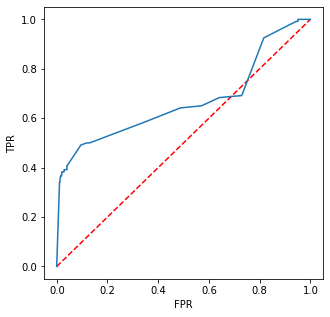

In [48]:
# 10.对预测结果评估
# 根据训练时的模型model，画出roc图像
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [49]:
# 计算AUC值
# 方法一：计算roc曲线下的面积
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(score_lable)
metrics.areaUnderROC
0.7364334522585716

In [71]:
# 方法二：将结果转成ndarray
from sklearn.metrics import accuracy_score,roc_auc_score
import numpy as np
arr = np.array(score_lable.collect())
arr

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [69]:
accuracy_score(arr[:,0],arr[:,1].round())

0.8969194312796208

In [70]:
roc_auc_score(arr[:,0],arr[:,1])

0.6688017955801104